<a href="https://colab.research.google.com/github/lfast1/CHE30324/blob/master/Copy_of_CBE_30338_Final_Project_Irradiance_Calculations_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CBE 30338 Final Project



## Installations and Imports

In [0]:
!pip install pysolar

In [0]:
# import libraries
from pysolar.solar import *
import datetime
import matplotlib.pyplot as plt
timezone = pytz.timezone("America/New_York")
import numpy as np

lat =  41.698417    # degrees latitude
lng = -86.236343    # degrees longitude

## Datetime Utility Functions

`datetime` returns a `datetime` object with a high degree of functionality.  We really don't need that functionality for this project, so let's build a few utility functions to make things simpler.  

The `timestamp()` method converts a datetime object to seconds since the start of the day on January 1, 1970 UTC.  We'll define the beginning of 2019 as the 'beginning of year'. (For some reason I need to add 240.0 to this result in order for the round trip conversion of datetime to timestamp and back to work out correctly.)

In [2]:
BOY = datetime.datetime(2018, 1, 1, 0, 0 ,0, tzinfo=timezone).timestamp() + 240.0
EOY = datetime.datetime(2018, 12, 31, 23, 59, 59, tzinfo=timezone).timestamp() + 240.0

days = (EOY - BOY)/24/3600
days

364.9999884259259

Next define a function `doy2datetime` the takes seconds since the year started and converts to a datetime object. Test by confirming a new year occurs at $365\times 24 \times 3600$ seconds in the future.

In [3]:
def seconds2date(t):
    return datetime.datetime.fromtimestamp(BOY + t, tz=timezone)
  
t = 365*24*3600
print('BOY: ', seconds2date(0))
print('EOY: ', seconds2date(t))

BOY:  2018-01-01 00:00:00-05:00
EOY:  2019-01-01 00:00:00-05:00


## Pysolar Utility Functions

We will use the Pysolar library to get the azimuth, elevation, and radiance of the sun as a function of time.

### Solar Elevation

The Pysolar package refers to elevation as `altitude`.  Here we create a function that returns elevation in degrees as a function of time of year in seconds.

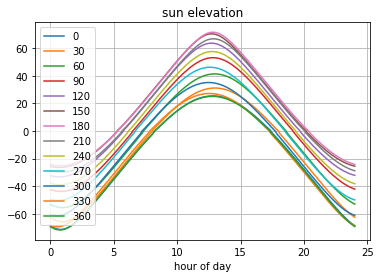

In [4]:
def elevation(t):
    return get_altitude(lat, lng, seconds2date(t))
  
# plot elevation for the 90th day of the year

t = np.linspace(0, 24*3600, 200)
for day in range(0, 365, 30):
  e = [elevation(t + day*24*3600) for t in t]
  plt.plot(t/3600, e, label=str(day))
  
plt.xlabel('hour of day')
plt.title('sun elevation')
plt.legend()
plt.grid(True)

### Solar Azimuth

Next we define an azimuth function that returns solar azimuth in degrees as a function of time of year in seconds.



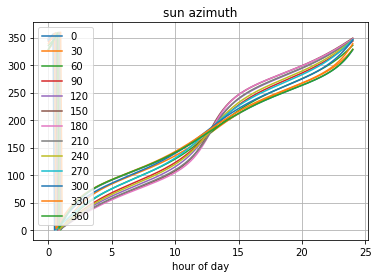

In [5]:
def azimuth(t):
    return get_azimuth(lat, lng, seconds2date(t))
  
# plot elevation for the 90th day of the year

t = np.linspace(0, 24*3600, 200)
for day in range(0, 365, 30):
  a = [azimuth(t + day*24*3600) for t in t]
  plt.plot(t/3600, a, label=str(day))
  
plt.xlabel('hour of day')
plt.title('sun azimuth')
plt.legend()
plt.grid(True)

### Plots of Solar Position as functions of day of year and time of day.

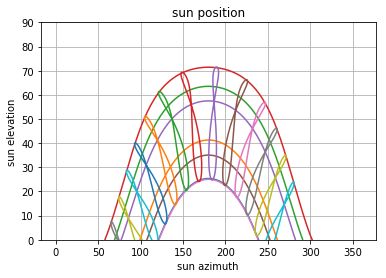

In [6]:
t = np.linspace(0, 24*3600, 200)
for day in range(0, 365, 60):
  a = [azimuth(t + day*24*3600) for t in t]
  e = [elevation(t + day*24*3600) for t in t]
  plt.plot(a, e, label=str(day))
  
day = np.linspace(0, 365, 366)
for t in 3600*np.linspace(6, 18, 13):
  a = [azimuth(t + day*24*3600) for day in day]
  e = [elevation(t + day*24*3600) for day in day]
  plt.plot(a, e, label=str(t))  
  
plt.xlabel('sun azimuth')
plt.ylabel('sun elevation')
plt.ylim(0, 90)
plt.title('sun position')
plt.grid(True)

### Solar Radiance

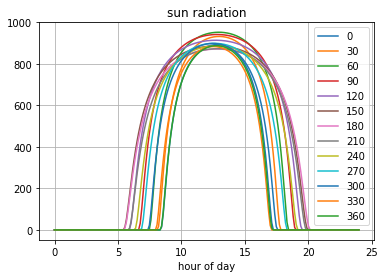

In [7]:
def radiance(t):
  date = seconds2date(t)
  return radiation.get_radiation_direct(date, get_altitude(lat, lng, date))

# plot elevation for the 90th day of the year

t = np.linspace(0, 24*3600, 200)
for day in range(0, 365, 30):
  r = [radiance(t + day*24*3600) for t in t]
  plt.plot(t/3600, r, label=str(day))
  
plt.xlabel('hour of day')
plt.title('sun radiation')
plt.legend()
plt.grid(True)

### Solar Panel Power

power factor = 0.4183


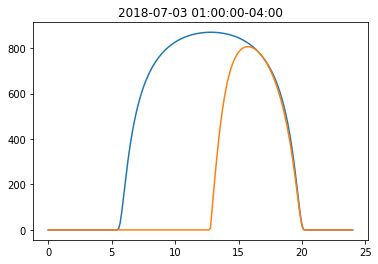

In [27]:
#@title Default title text { run: "auto" }
day = 183 #@param {type:"slider", min:0, max:365, step:1}
beta = 59 #@param {type:"slider", min:0, max:90, step:1}
phi = 268 #@param {type:"slider", min:0, max:360, step:1}

def panel_power(t, beta, phi):
  alpha = elevation(t)
  omega = azimuth(t)
  beta = 90-alpha
  geom_eff = max(0,np.sin((alpha+beta)*np.pi/180.0)*np.cos((omega-phi)*np.pi/180))
  return geom_eff*radiance(t)

def doy(day, beta, phi):
  t = np.linspace(0, 24*3600, 200)
  r = [radiance(t +  day*24*3600) for t in t]
  p = [panel_power(t + day*24*3600, beta, phi) for t in t]
  plt.plot(t/3600, r, label=str(day))
  plt.plot(t/3600, p, label=str(day))
  plt.title(seconds2date(day*24*3600))
  pf = sum(p)/sum(r)
  print('power factor =', round(pf,4))
  
doy(day, beta, phi)

## Irradiance Calculations

In [0]:
# initialize vectors
days = []
date = []
bla = []
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
dm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# extract datetime information for each hour of each day for one year, iterating by days of each month
for i in range(0,12):
    for j in range(0,dm[i]):   
        days.append(j+1)
        date.append(datetime.datetime(2018,months[i],j+1).toordinal())
        for k in range(0,24):
            bla.append(datetime.datetime(2018,months[i],j+1,k,0,0,0,tzinfo=timezone))

In [0]:
# set parameters
long = -86.236343 # degrees longitude
lat = 41.698417 # degrees latitude

# initialize vectors
alt = []
rad = []

# calculate altitude and direct radiation for each hour of each day for a year
for z in range(0,len(bla)):
    alt.append(get_altitude(lat, long, bla[z]))
    rad.append(radiation.get_radiation_direct(bla[z], alt[z]))    

Text(0, 0.5, 'irradiation (W/m2)')

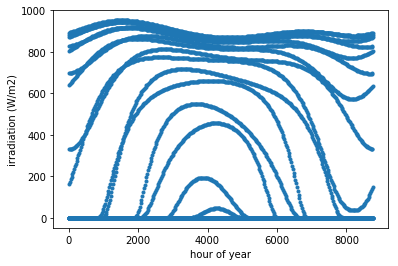

In [0]:
# hours in a year
beep = np.linspace(1,8760,8760)
#hours in a day
blop = np.linspace(1,24,24)

# plot direct radiation for each hour for an entire year
plt.plot(beep,rad,'.')
plt.xlabel('hour of year')
plt.ylabel('irradiation (W/m2)')

In [0]:
# create vectors for each month, corresponding to the keys from datetime
jan = date[0:31]
feb = date[31:(31+28)]
mar = date[(31+28):(31+28+31)]
apr = date[(31+28+31):(31+28+31+30)]
may = date[(31+28+31+30):(31+28+31+30+31)]
jun = date[(31+28+31+30+31):(31+28+31+30+31+30)]
jul = date[(31+28+31+30+31+30):(31+28+31+30+31+30+31)]
aug = date[(31+28+31+30+31+30+31):(31+28+31+30+31+30+31+31)]
sep = date[(31+28+31+30+31+30+31+31):(31+28+31+30+31+30+31+31+30)]
ock = date[(31+28+31+30+31+30+31+31+30):(31+28+31+30+31+30+31+31+30+31)]
nov = date[(31+28+31+30+31+30+31+31+30+31):(31+28+31+30+31+30+31+31+30+31+30)]
dec = date[(31+28+31+30+31+30+31+31+30+31+30):(31+28+31+30+31+30+31+31+30+31+30+31)]

# initialize vectors
d1 = []
d2 = []
d3 = []
d4 = []
d5 = []
d6 = []
d7 = []
d8 = []
d9 = []
d10 = []
d11 = []
d12 = []

In [0]:
# for each month, extract datetime information for each hour of each day

for j in range(0,len(jan)):
    for k in range(0,24):
        d1.append(datetime.datetime(2018,1,j+1,k,0,0,0,tzinfo=timezone))
        
for j in range(0,len(feb)):
    for k in range(0,24):
        d2.append(datetime.datetime(2018,2,j+1,k,0,0,0,tzinfo=timezone))

for j in range(0,len(mar)):
    for k in range(0,24):
        d3.append(datetime.datetime(2018,3,j+1,k,0,0,0,tzinfo=timezone))
        
for j in range(0,len(apr)):
    for k in range(0,24):
        d4.append(datetime.datetime(2018,4,j+1,k,0,0,0,tzinfo=timezone))
        
for j in range(0,len(may)):
    for k in range(0,24):
        d5.append(datetime.datetime(2018,5,j+1,k,0,0,0,tzinfo=timezone))

for j in range(0,len(jun)):
    for k in range(0,24):
        d6.append(datetime.datetime(2018,6,j+1,k,0,0,0,tzinfo=timezone))

for j in range(0,len(jul)):
    for k in range(0,24):
        d7.append(datetime.datetime(2018,7,j+1,k,0,0,0,tzinfo=timezone))
        
for j in range(0,len(aug)):
    for k in range(0,24):
        d8.append(datetime.datetime(2018,8,j+1,k,0,0,0,tzinfo=timezone))

for j in range(0,len(sep)):
    for k in range(0,24):
        d9.append(datetime.datetime(2018,9,j+1,k,0,0,0,tzinfo=timezone))
        
for j in range(0,len(ock)):
    for k in range(0,24):
        d10.append(datetime.datetime(2018,10,j+1,k,0,0,0,tzinfo=timezone))
        
for j in range(0,len(nov)):
    for k in range(0,24):
        d11.append(datetime.datetime(2018,11,j+1,k,0,0,0,tzinfo=timezone))

for j in range(0,len(dec)):
    for k in range(0,24):
        d12.append(datetime.datetime(2018,12,j+1,k,0,0,0,tzinfo=timezone))

In [0]:
long = -86.236343 # degrees longitude
lat = 41.698417 # degrees latitude

# initialize vectors to calculate altitude and direct radiation for each month
alt1 = []
rad1 = []
alt2 = []
rad2 = []
alt3 = []
rad3 = []
alt4 = []
rad4 = []
alt5 = []
rad5 = []
alt6 = []
rad6 = []
alt7 = []
rad7 = []
alt8 = []
rad8 = []
alt9 = []
rad9 = []
alt10 = []
rad10 = []
alt11 = []
rad11 = []
alt12 = []
rad12 = []

# calculate altitude and radiation for each hour of each day, for each month

for z in range(0,len(d1)):
    alt1.append(get_altitude(lat, long, d1[z]))
    rad1.append(radiation.get_radiation_direct(d1[z], alt1[z]))

for z in range(0,len(d2)):
    alt2.append(get_altitude(lat, long, d2[z]))
    rad2.append(radiation.get_radiation_direct(d2[z], alt2[z]))
    
for z in range(0,len(d3)):
    alt3.append(get_altitude(lat, long, d3[z]))
    rad3.append(radiation.get_radiation_direct(d3[z], alt3[z]))

for z in range(0,len(d4)):
    alt4.append(get_altitude(lat, long, d4[z]))
    rad4.append(radiation.get_radiation_direct(d4[z], alt4[z]))
    
for z in range(0,len(d5)):
    alt5.append(get_altitude(lat, long, d5[z]))
    rad5.append(radiation.get_radiation_direct(d5[z], alt5[z]))

for z in range(0,len(d6)):
    alt6.append(get_altitude(lat, long, d6[z]))
    rad6.append(radiation.get_radiation_direct(d6[z], alt6[z]))
    
for z in range(0,len(d7)):
    alt7.append(get_altitude(lat, long, d7[z]))
    rad7.append(radiation.get_radiation_direct(d7[z], alt7[z]))

for z in range(0,len(d8)):
    alt8.append(get_altitude(lat, long, d8[z]))
    rad8.append(radiation.get_radiation_direct(d8[z], alt8[z]))
    
for z in range(0,len(d9)):
    alt9.append(get_altitude(lat, long, d9[z]))
    rad9.append(radiation.get_radiation_direct(d9[z], alt9[z]))

for z in range(0,len(d10)):
    alt10.append(get_altitude(lat, long, d10[z]))
    rad10.append(radiation.get_radiation_direct(d10[z], alt10[z]))
    
for z in range(0,len(d11)):
    alt11.append(get_altitude(lat, long, d11[z]))
    rad11.append(radiation.get_radiation_direct(d11[z], alt11[z]))

for z in range(0,len(d12)):
    alt12.append(get_altitude(lat, long, d12[z]))
    rad12.append(radiation.get_radiation_direct(d12[z], alt12[z]))
    

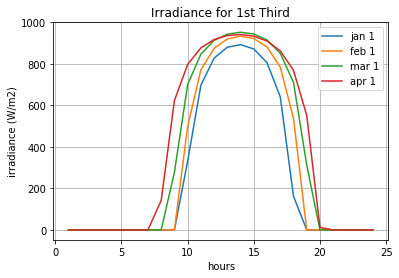

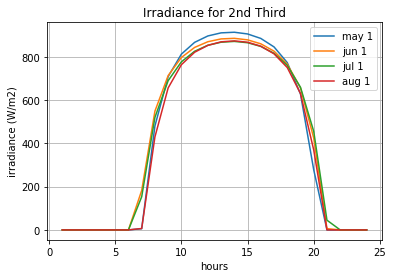

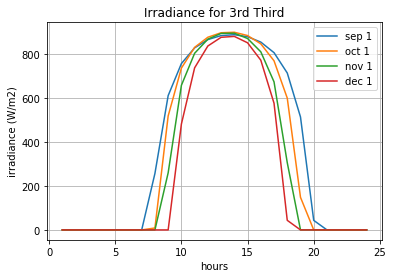

In [0]:
# hours in a day
x = np.linspace(1,24,24)

# plot irradiances for 1st of each month, split into thirds

plt.figure(1)
plt.plot(x,rad1[0:24],x,rad2[0:24],x,rad3[0:24],x,rad4[0:24])
plt.legend(['jan 1','feb 1','mar 1','apr 1'])
plt.xlabel('hours')
plt.ylabel('irradiance (W/m2)')
plt.title('Irradiance for 1st Third')
plt.grid()

plt.figure(2)
plt.plot(x,rad5[0:24],x,rad6[0:24],x,rad7[0:24],x,rad8[0:24])
plt.legend(['may 1','jun 1','jul 1','aug 1'])
plt.xlabel('hours')
plt.ylabel('irradiance (W/m2)')
plt.title('Irradiance for 2nd Third')
plt.grid()

plt.figure(3)
plt.plot(x,rad9[0:24],x,rad10[0:24],x,rad11[0:24],x,rad12[0:24])
plt.legend(['sep 1','oct 1','nov 1','dec 1'])
plt.xlabel('hours')
plt.ylabel('irradiance (W/m2)')
plt.title('Irradiance for 3rd Third')
plt.grid()

Text(0.5, 1.0, 'December average daily irradiance')

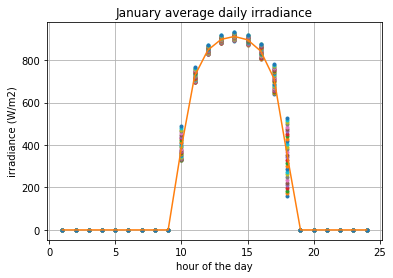

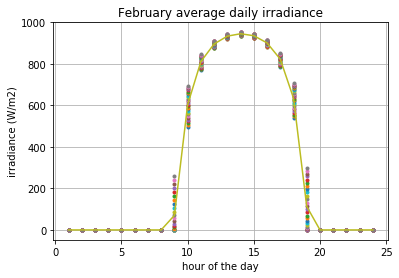

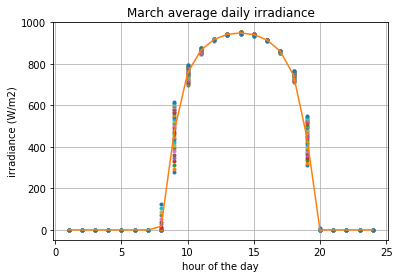

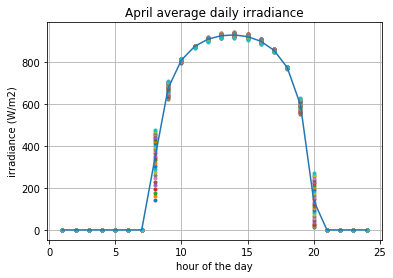

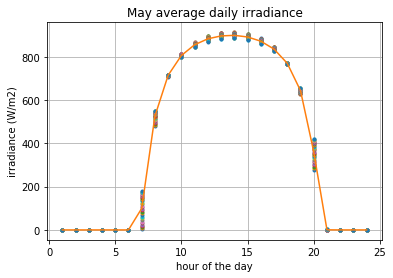

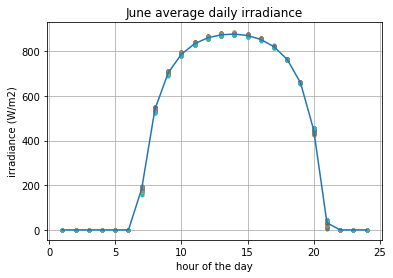

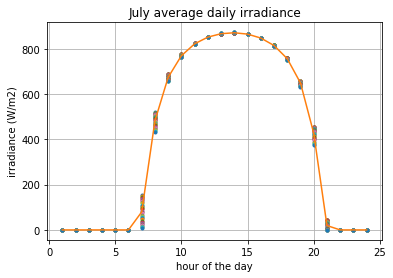

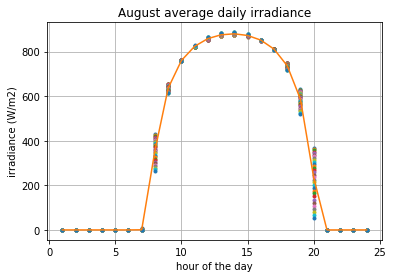

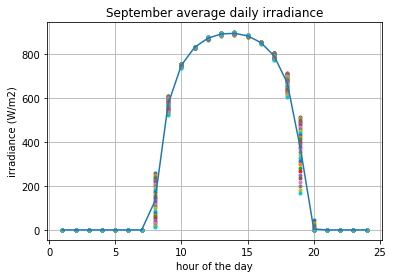

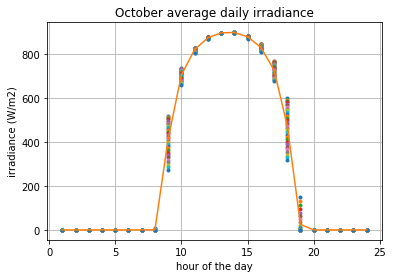

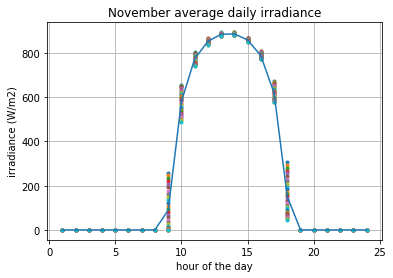

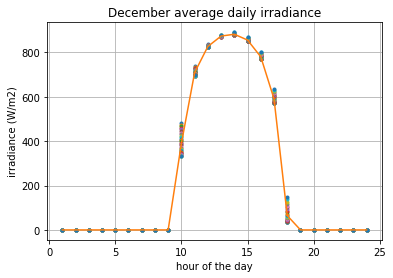

In [0]:
import statistics

x = np.linspace(1,24,24)

# initialize vectors for calculating averages
jan_avg = []
feb_avg = []
mar_avg = []
apr_avg = []
may_avg = []
jun_avg = []
jul_avg = []
aug_avg = []
sep_avg = []
oct_avg = []
nov_avg = []
dec_avg = []

# find the average irradiation for each hour by averaging each day and plot

plt.figure(1)
jan_ent = np.zeros([dm[0],24])
for i in range(0,dm[0]):
    jan_ent[i,:] = rad1[24*i : 24*(i+1)]
    plt.plot(x,jan_ent[i,:],'.')
for j in range(0,len(x)):
    jan_avg.append(statistics.mean(jan_ent[:,j]))
plt.plot(x,jan_avg)
plt.xlabel('hour of the day')
plt.ylabel('irradiance (W/m2)')
plt.grid()
plt.title('January average daily irradiance')
       
plt.figure(2)
feb_ent = np.zeros([dm[1],24])
for i in range(0,dm[1]):
    feb_ent[i,:] = rad2[24*i : 24*(i+1)]
    plt.plot(x,feb_ent[i,:],'.')
for j in range(0,len(x)):
    feb_avg.append(statistics.mean(feb_ent[:,j]))
plt.plot(x,feb_avg)
plt.xlabel('hour of the day')
plt.ylabel('irradiance (W/m2)')
plt.grid()
plt.title('February average daily irradiance')

plt.figure(3)
mar_ent = np.zeros([dm[2],24])
for i in range(0,dm[2]):
    mar_ent[i,:] = rad3[24*i : 24*(i+1)]
    plt.plot(x,mar_ent[i,:],'.')
for j in range(0,len(x)):
    mar_avg.append(statistics.mean(mar_ent[:,j]))
plt.plot(x,mar_avg)
plt.xlabel('hour of the day')
plt.ylabel('irradiance (W/m2)')
plt.grid()
plt.title('March average daily irradiance')

plt.figure(4)
apr_ent = np.zeros([dm[3],24])
for i in range(0,dm[3]):
    apr_ent[i,:] = rad4[24*i : 24*(i+1)]
    plt.plot(x,apr_ent[i,:],'.')
for j in range(0,len(x)):
    apr_avg.append(statistics.mean(apr_ent[:,j]))
plt.plot(x,apr_avg)
plt.xlabel('hour of the day')
plt.ylabel('irradiance (W/m2)')
plt.grid()
plt.title('April average daily irradiance')

plt.figure(5)
may_ent = np.zeros([dm[4],24])
for i in range(0,dm[4]):
    may_ent[i,:] = rad5[24*i : 24*(i+1)]
    plt.plot(x,may_ent[i,:],'.')
for j in range(0,len(x)):
    may_avg.append(statistics.mean(may_ent[:,j]))
plt.plot(x,may_avg)
plt.xlabel('hour of the day')
plt.ylabel('irradiance (W/m2)')
plt.grid()
plt.title('May average daily irradiance')
    
plt.figure(6)
jun_ent = np.zeros([dm[5],24])
for i in range(0,dm[5]):
    jun_ent[i,:] = rad6[24*i : 24*(i+1)]
    plt.plot(x,jun_ent[i,:],'.')
for j in range(0,len(x)):
    jun_avg.append(statistics.mean(jun_ent[:,j]))
plt.plot(x,jun_avg)
plt.xlabel('hour of the day')
plt.ylabel('irradiance (W/m2)')
plt.grid()
plt.title('June average daily irradiance')
    
plt.figure(7)
jul_ent = np.zeros([dm[6],24])
for i in range(0,dm[6]):
    jul_ent[i,:] = rad7[24*i : 24*(i+1)]
    plt.plot(x,jul_ent[i,:],'.')
for j in range(0,len(x)):
    jul_avg.append(statistics.mean(jul_ent[:,j]))
plt.plot(x,jul_avg)
plt.xlabel('hour of the day')
plt.ylabel('irradiance (W/m2)')
plt.grid()
plt.title('July average daily irradiance')
    
plt.figure(8)
aug_ent = np.zeros([dm[7],24])
for i in range(0,dm[7]):
    aug_ent[i,:] = rad8[24*i : 24*(i+1)]
    plt.plot(x,aug_ent[i,:],'.')
for j in range(0,len(x)):
    aug_avg.append(statistics.mean(aug_ent[:,j]))
plt.plot(x,aug_avg)
plt.xlabel('hour of the day')
plt.ylabel('irradiance (W/m2)')
plt.grid()
plt.title('August average daily irradiance')
    
plt.figure(9)
sep_ent = np.zeros([dm[8],24])
for i in range(0,dm[8]):
    sep_ent[i,:] = rad9[24*i : 24*(i+1)]
    plt.plot(x,sep_ent[i,:],'.')
for j in range(0,len(x)):
    sep_avg.append(statistics.mean(sep_ent[:,j]))
plt.plot(x,sep_avg)
plt.xlabel('hour of the day')
plt.ylabel('irradiance (W/m2)')
plt.grid()
plt.title('September average daily irradiance')
    
plt.figure(10)
oct_ent = np.zeros([dm[9],24])
for i in range(0,dm[9]):
    oct_ent[i,:] = rad10[24*i : 24*(i+1)]
    plt.plot(x,oct_ent[i,:],'.')
for j in range(0,len(x)):
    oct_avg.append(statistics.mean(oct_ent[:,j]))
plt.plot(x,oct_avg)
plt.xlabel('hour of the day')
plt.ylabel('irradiance (W/m2)')
plt.grid()
plt.title('October average daily irradiance')
    
plt.figure(11)
nov_ent = np.zeros([dm[10],24])
for i in range(0,dm[10]):
    nov_ent[i,:] = rad11[24*i : 24*(i+1)]
    plt.plot(x,nov_ent[i,:],'.')
for j in range(0,len(x)):
    nov_avg.append(statistics.mean(nov_ent[:,j]))
plt.plot(x,nov_avg)
plt.xlabel('hour of the day')
plt.ylabel('irradiance (W/m2)')
plt.grid()
plt.title('November average daily irradiance')
    
plt.figure(12)
dec_ent = np.zeros([dm[11],24])
for i in range(0,dm[11]):
    dec_ent[i,:] = rad12[24*i : 24*(i+1)]
    plt.plot(x,dec_ent[i,:],'.')
for j in range(0,len(x)):
    dec_avg.append(statistics.mean(dec_ent[:,j]))
plt.plot(x,dec_avg)
plt.xlabel('hour of the day')
plt.ylabel('irradiance (W/m2)')
plt.grid()
plt.title('December average daily irradiance')
       

Text(0.5, 1.0, 'December Average Fit')

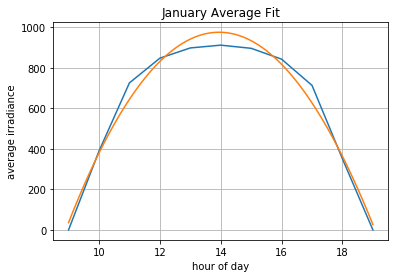

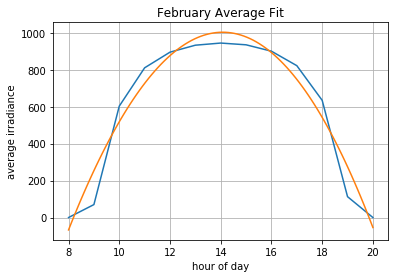

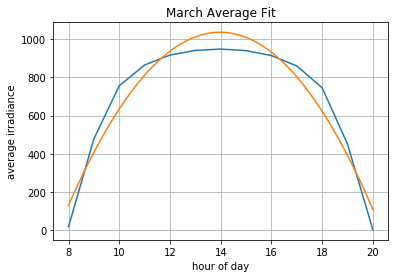

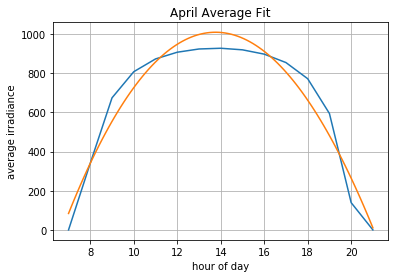

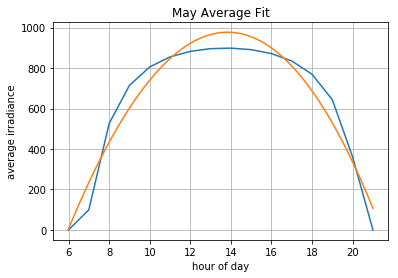

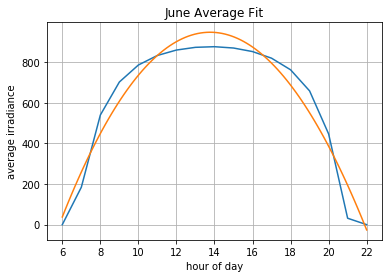

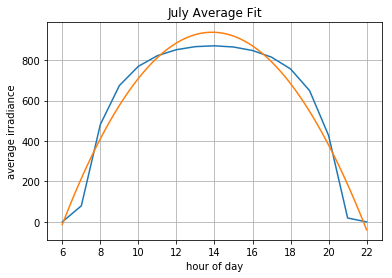

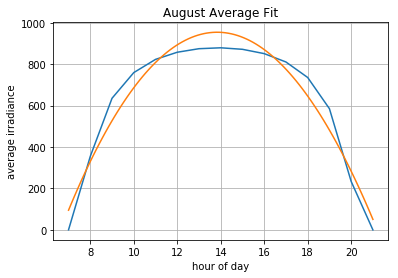

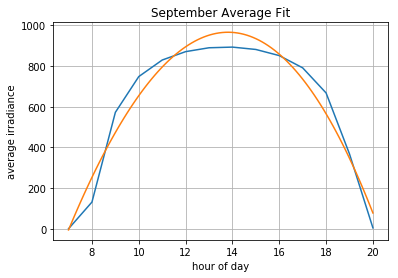

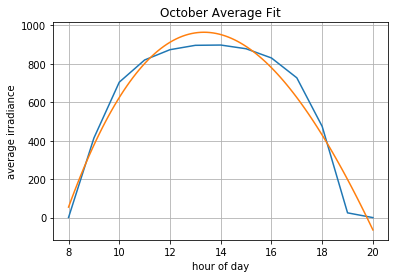

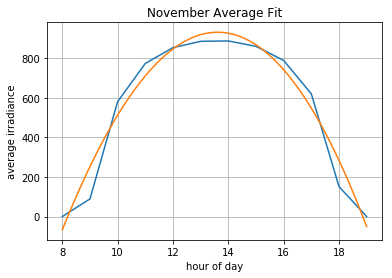

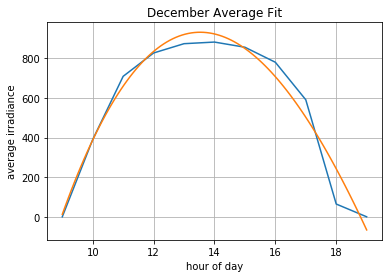

In [0]:
# fit a polynomial to the average irradiation data and plot

plt.figure(1)
jan_fit = np.polyfit(x[8:19],jan_avg[8:19],3)
z = np.linspace(9,19,100)
jan_p = jan_fit[0]*z**3 + jan_fit[1]*z**2 + jan_fit[2]*z**1 + jan_fit[3]*z**0
plt.plot(x[8:19],jan_avg[8:19],z,jan_p)
plt.xlabel('hour of day')
plt.ylabel('average irradiance')
plt.grid()
plt.title('January Average Fit')

plt.figure(2)
feb_fit = np.polyfit(x[7:20],feb_avg[7:20],3)
z = np.linspace(8,20,100)
feb_p = feb_fit[0]*z**3 + feb_fit[1]*z**2 + feb_fit[2]*z**1 + feb_fit[3]*z**0
plt.plot(x[7:20],feb_avg[7:20],z,feb_p)
plt.xlabel('hour of day')
plt.ylabel('average irradiance')
plt.grid()
plt.title('February Average Fit')

plt.figure(3)
mar_fit = np.polyfit(x[7:20],mar_avg[7:20],3)
z = np.linspace(8,20,100)
mar_p = mar_fit[0]*z**3 + mar_fit[1]*z**2 + mar_fit[2]*z**1 + mar_fit[3]*z**0
plt.plot(x[7:20],mar_avg[7:20],z,mar_p)
plt.xlabel('hour of day')
plt.ylabel('average irradiance')
plt.grid()
plt.title('March Average Fit')

plt.figure(4)
apr_fit = np.polyfit(x[6:21],apr_avg[6:21],3)
z = np.linspace(7,21,100)
apr_p = apr_fit[0]*z**3 + apr_fit[1]*z**2 + apr_fit[2]*z**1 + apr_fit[3]*z**0
plt.plot(x[6:21],apr_avg[6:21],z,apr_p)
plt.xlabel('hour of day')
plt.ylabel('average irradiance')
plt.grid()
plt.title('April Average Fit')

plt.figure(5)
may_fit = np.polyfit(x[5:21],may_avg[5:21],3)
z = np.linspace(6,21,100)
may_p = may_fit[0]*z**3 + may_fit[1]*z**2 + may_fit[2]*z**1 + may_fit[3]*z**0
plt.plot(x[5:21],may_avg[5:21],z,may_p)
plt.xlabel('hour of day')
plt.ylabel('average irradiance')
plt.grid()
plt.title('May Average Fit')

plt.figure(6)
jun_fit = np.polyfit(x[5:22],jun_avg[5:22],3)
z = np.linspace(6,22,100)
jun_p = jun_fit[0]*z**3 + jun_fit[1]*z**2 + jun_fit[2]*z**1 + jun_fit[3]*z**0
plt.plot(x[5:22],jun_avg[5:22],z,jun_p)
plt.xlabel('hour of day')
plt.ylabel('average irradiance')
plt.grid()
plt.title('June Average Fit')

plt.figure(7)
jul_fit = np.polyfit(x[5:22],jul_avg[5:22],3)
z = np.linspace(6,22,100)
jul_p = jul_fit[0]*z**3 + jul_fit[1]*z**2 + jul_fit[2]*z**1 + jul_fit[3]*z**0
plt.plot(x[5:22],jul_avg[5:22],z,jul_p)
plt.xlabel('hour of day')
plt.ylabel('average irradiance')
plt.grid()
plt.title('July Average Fit')

plt.figure(8)
aug_fit = np.polyfit(x[6:21],aug_avg[6:21],3)
z = np.linspace(7,21,100)
aug_p = aug_fit[0]*z**3 + aug_fit[1]*z**2 + aug_fit[2]*z**1 + aug_fit[3]*z**0
plt.plot(x[6:21],aug_avg[6:21],z,aug_p)
plt.xlabel('hour of day')
plt.ylabel('average irradiance')
plt.grid()
plt.title('August Average Fit')

plt.figure(9)
sep_fit = np.polyfit(x[6:20],sep_avg[6:20],3)
z = np.linspace(7,20,100)
sep_p = sep_fit[0]*z**3 + sep_fit[1]*z**2 + sep_fit[2]*z**1 + sep_fit[3]*z**0
plt.plot(x[6:20],sep_avg[6:20],z,sep_p)
plt.xlabel('hour of day')
plt.ylabel('average irradiance')
plt.grid()
plt.title('September Average Fit')

plt.figure(10)
oct_fit = np.polyfit(x[7:20],oct_avg[7:20],3)
z = np.linspace(8,20,100)
oct_p = oct_fit[0]*z**3 + oct_fit[1]*z**2 + oct_fit[2]*z**1 + oct_fit[3]*z**0
plt.plot(x[7:20],oct_avg[7:20],z,oct_p)
plt.xlabel('hour of day')
plt.ylabel('average irradiance')
plt.grid()
plt.title('October Average Fit')

plt.figure(11)
nov_fit = np.polyfit(x[7:19],nov_avg[7:19],3)
z = np.linspace(8,19,100)
nov_p = nov_fit[0]*z**3 + nov_fit[1]*z**2 + nov_fit[2]*z**1 + nov_fit[3]*z**0
plt.plot(x[7:19],nov_avg[7:19],z,nov_p)
plt.xlabel('hour of day')
plt.ylabel('average irradiance')
plt.grid()
plt.title('November Average Fit')

plt.figure(12)
dec_fit = np.polyfit(x[8:19],dec_avg[8:19],3)
z = np.linspace(9,19,100)
dec_p = dec_fit[0]*z**3 + dec_fit[1]*z**2 + dec_fit[2]*z**1 + dec_fit[3]*z**0
plt.plot(x[8:19],dec_avg[8:19],z,dec_p)
plt.xlabel('hour of day')
plt.ylabel('average irradiance')
plt.grid()
plt.title('December Average Fit')

In [0]:
# import library
from sympy import *

# set variable for integration
z = Symbol('z', Positive=true)

# recast the fitted polynomials in terms of the symbol z
jan_p = jan_fit[0]*z**3 + jan_fit[1]*z**2 + jan_fit[2]*z**1 + jan_fit[3]*z**0
feb_p = feb_fit[0]*z**3 + feb_fit[1]*z**2 + feb_fit[2]*z**1 + feb_fit[3]*z**0
mar_p = mar_fit[0]*z**3 + mar_fit[1]*z**2 + mar_fit[2]*z**1 + mar_fit[3]*z**0
apr_p = apr_fit[0]*z**3 + apr_fit[1]*z**2 + apr_fit[2]*z**1 + apr_fit[3]*z**0
may_p = may_fit[0]*z**3 + may_fit[1]*z**2 + may_fit[2]*z**1 + may_fit[3]*z**0
jun_p = jun_fit[0]*z**3 + jun_fit[1]*z**2 + jun_fit[2]*z**1 + jun_fit[3]*z**0
jul_p = jul_fit[0]*z**3 + jul_fit[1]*z**2 + jul_fit[2]*z**1 + jul_fit[3]*z**0
aug_p = aug_fit[0]*z**3 + aug_fit[1]*z**2 + aug_fit[2]*z**1 + aug_fit[3]*z**0
sep_p = sep_fit[0]*z**3 + sep_fit[1]*z**2 + sep_fit[2]*z**1 + sep_fit[3]*z**0
oct_p = oct_fit[0]*z**3 + oct_fit[1]*z**2 + oct_fit[2]*z**1 + oct_fit[3]*z**0
nov_p = nov_fit[0]*z**3 + nov_fit[1]*z**2 + nov_fit[2]*z**1 + nov_fit[3]*z**0
dec_p = dec_fit[0]*z**3 + dec_fit[1]*z**2 + dec_fit[2]*z**1 + dec_fit[3]*z**0

# integrate the polynomials
jan_int = integrate(jan_p, (z,9,19))
feb_int = integrate(feb_p, (z,8,20))
mar_int = integrate(mar_p, (z,8,20))
apr_int = integrate(apr_p, (z,7,21))
may_int = integrate(may_p, (z,6,21))
jun_int = integrate(jun_p, (z,6,22))
jul_int = integrate(jul_p, (z,6,22))
aug_int = integrate(aug_p, (z,7,21))
sep_int = integrate(sep_p, (z,7,20))
oct_int = integrate(oct_p, (z,8,20))
nov_int = integrate(nov_p, (z,8,19))
dec_int = integrate(dec_p, (z,9,19))

# average irradiation for a day of each month, from sunrise to sunset
# units? irradiance [=] W/m2 => not sure about after integration
print(jan_int)
print(feb_int)
print(mar_int)
print(apr_int)
print(may_int)
print(jun_int)
print(jul_int)
print(aug_int)
print(sep_int)
print(oct_int)
print(nov_int)
print(dec_int)

6604.79256501793
7778.94171275448
8769.03178749275
9635.06357384791
10034.7940622381
10133.3348415361
9856.79421387320
9244.76759305142
8511.03879235513
7599.71760735267
6602.50080855995
6060.74749815390
